<a href="https://colab.research.google.com/github/noircir/TensorFlow-Examples/blob/master/TF1_04_Regression_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import tensorflow as tf

In [24]:
# 1 Million Points
x_data = np.linspace(0.0,10.0,1000000)
x_data

array([0.000000e+00, 1.000001e-05, 2.000002e-05, ..., 9.999980e+00,
       9.999990e+00, 1.000000e+01])

In [25]:
noise = np.random.randn(len(x_data))
noise

array([ 1.18084663, -0.84320752, -0.84591664, ...,  0.53329064,
       -1.23202101,  2.27905132])

In [0]:
# y = mx + b = 0.5x + 5 + noise

y_true = (0.5* x_data) + 5 + noise  

In [27]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)
my_data.head()

,X Data,Y
0,0.00000,6.180847
1,0.00001,4.156797
2,0.00002,4.154093
3,0.00003,6.302463
4,0.00004,4.015234


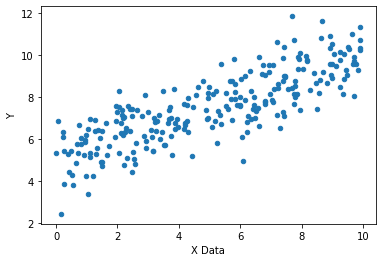

In [28]:
# plot of a million points is too much ... Plot a sample
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y');

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [0]:
# Random 8 points to grab
batch_size = 8

In [30]:
np.random.randn(2)

array([-0.1797644 ,  0.05305113])

### Variables

y = mx + b

In [0]:
m = tf.Variable(1.26)
b = tf.Variable(-2.03)

### Placeholders

In [0]:
x_placeholder = tf.placeholder(tf.float32,[batch_size])
y_placeholder = tf.placeholder(tf.float32,[batch_size])

### Graph

In [0]:
y_model = m*x_placeholder + b

### Loss function


In [0]:
# tf.math.square(x) computes square of x element-wise
# tf.math.reduce_sum(x, axis=None, keepdims=None, name=None) computes the sum of elements across dimensions of a tensor

error = tf.reduce_sum(tf.square(y_placeholder-y_model))

### Optimizer

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

### Initialize variables

In [0]:
init = tf.global_variables_initializer()

### Session

In [38]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 1000
    
    for i in range(batches):

        # choose 8 random data points from x_data (batch size = 8)
        # np.random.randint returns a ndarray of integers

        rand_index = np.random.randint(len(x_data),size=batch_size)
        if i%100 == 0:
          print("Random index:", rand_index)
        
        feed = {x_placeholder:x_data[rand_index],y_placeholder:y_true[rand_index]}
        
        sess.run(train,feed_dict=feed)
        
    model_m, model_b = sess.run([m,b])

Random index: [975727 964084 950664  15028 730734  51772  77828 695512]
Random index: [ 24285  38360 357049 623320  86147 601419 852066 208890]
Random index: [652450 780997 548301 568441  31612 259854 983318 422465]
Random index: [609352 339529 509026 298722 244388 268927 984447  59737]
Random index: [ 24705 885681 921268 364784 367488 911697  80863 986766]
Random index: [ 19812 895516 347939 972053 631311 830485 935759 177603]
Random index: [427007 970101 281997 471699 699238 172829 825074 363219]
Random index: [967759 901869 775571 790805 575182 208931 951800 548447]
Random index: [911182 435020 497229  37291 521327 257617  97755 495790]
Random index: [281707 120651 130720 160175 197662 314897  92989 542196]


In [39]:
# The true line was y_true = (0.5* x_data) + 5 + noise  
# We started from random m and b: array([-0.1797644 ,  0.05305113])
# The predicted line accounts for the noise, as well

print(model_m, '\n', model_b)

0.54447216 
 4.852162


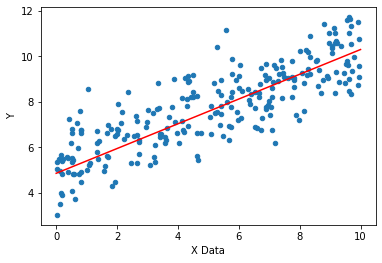

In [41]:
y_hat = x_data * model_m + model_b

my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r');

## tf.estimator API

Much simpler API for basic tasks like regression! We'll talk about more abstractions like TF-Slim later on.

In [0]:
feature_cols = [ tf.feature_column.numeric_column('x',shape=[1]) ]

estimator = tf.estimator.LinearRegressor(feature_columns=feature_cols)

### Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [44]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [0]:
# acts as feed dictionary and batch size all in one

# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)


eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)


### Train the Estimator

In [0]:
estimator.train(input_fn=input_func,steps=1000)

### Evaluation

In [0]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

In [0]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

In [49]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 1.1449581, 'label/mean': 7.526784, 'loss': 4.5798326, 'prediction/mean': 7.3411107, 'global_step': 1000}
eval metrics: {'average_loss': 1.1359198, 'label/mean': 7.464932, 'loss': 4.543679, 'prediction/mean': 7.3001747, 'global_step': 1000}


In [0]:
# a good indicator of overfitting: low loss on training data, high loss on test (eval) data

### Predictions

In [0]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [0]:
list(estimator.predict(input_fn=input_fn_predict))

In [0]:
predictions = []   # np.array([])
for y_pred in estimator.predict(input_fn=input_fn_predict):
    predictions.append(y_pred['predictions'])  # appending a value from an array of dictionaries

In [53]:
predictions

[array([4.1880713], dtype=float32),
 array([4.884578], dtype=float32),
 array([5.5810847], dtype=float32),
 array([6.2775917], dtype=float32),
 array([6.974098], dtype=float32),
 array([7.6706047], dtype=float32),
 array([8.367111], dtype=float32),
 array([9.063619], dtype=float32),
 array([9.760126], dtype=float32),
 array([10.456633], dtype=float32)]

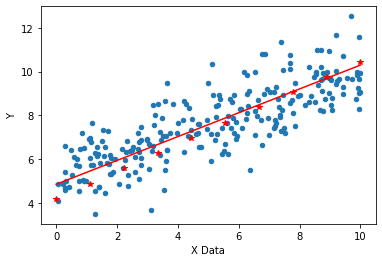

In [57]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r*')
# the line is the old prediction with graph
plt.plot(x_data,y_hat,'r');